In [ ]:

from keras.layers import *
from keras.models import Model
from keras import optimizers


In [ ]:
pip install opencv-python

In [ ]:
pip install tqdm

In [ ]:
pip install seaborn

In [ ]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from tensorflow.keras.applications import ResNet50, Xception, ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [ ]:
TEST_SIZE = 0.5
RANDOM_STATE = 2020
BATCH_SIZE = 64
classes = 2
IMG_SIZE = 224

In [ ]:
# ResNet building block of two layers
def building_block(X, filter_size, filters, stride=1):

    # Save the input value for shortcut
    X_shortcut = X

    # Reshape shortcut for later adding if dimensions change
    if stride > 1:

        X_shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # First layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=stride, padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = add([X, X_shortcut])  # Add shortcut value to main path
    X = Activation('relu')(X)

    return X


In [ ]:
# Full model
def create_model(input_shape, classes, name):

    # Define the input
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 2
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)

    # Stage 3
    X = building_block(X, filter_size=3, filters=32, stride=2)  # dimensions change (stride=2)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)

    # Stage 4
    X = building_block(X, filter_size=3, filters=64, stride=2)  # dimensions change (stride=2)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)

    # Average pooling and output layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name=name)

    return model

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
input_shape=IMAGE_SIZE + [3]

In [ ]:
# Define optimizer and compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ResNet32 = create_model(input_shape=input_shape, classes=classes, name='ResNet32')
ResNet32.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
!unzip /content/drive/MyDrive/test_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/test_data_224.zip
  inflating: /content/drive/MyDrive/dogs_cats/test_data_224.npy  


In [ ]:
!unzip /content/drive/MyDrive/train_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/train_data_224.zip
  inflating: /content/drive/MyDrive/dogs_cats/train_data_224.npy  


In [ ]:
train_data = np.load('/content/drive/MyDrive/dogs_cats/train_data_224.npy',allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/dogs_cats/test_data_224.npy',allow_pickle=True)

In [ ]:
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
# Train model
train_model = ResNet32.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 147s 641ms/step - loss: 0.6828 - accuracy: 0.5998 - val_loss: 0.7045 - val_accuracy: 0.5547
Epoch 2/10
196/196 [==============================] - 123s 629ms/step - loss: 0.6261 - accuracy: 0.6479 - val_loss: 0.8020 - val_accuracy: 0.5320
Epoch 3/10
196/196 [==============================] - 123s 629ms/step - loss: 0.5885 - accuracy: 0.6860 - val_loss: 0.8210 - val_accuracy: 0.5662
Epoch 4/10
196/196 [==============================] - 123s 629ms/step - loss: 0.5448 - accuracy: 0.7270 - val_loss: 0.9083 - val_accuracy: 0.5508
Epoch 5/10
196/196 [==============================] - 123s 628ms/step - loss: 0.5039 - accuracy: 0.7566 - val_loss: 0.6703 - val_accuracy: 0.6829
Epoch 6/10
196/196 [==============================] - 123s 628ms/step - loss: 0.4831 - accuracy: 0.7701 - val_loss: 0.6924 - val_accuracy: 0.6294
Epoch 7/10
196/196 [==============================] - 123s 628ms/step - loss: 0.4514 - accuracy: 0.7930 - val_loss: 0.5731 -

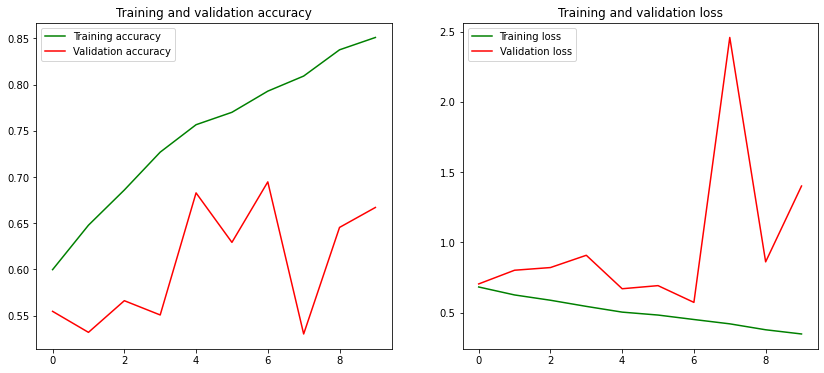

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = ResNet32.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.401079535484314
Validation accuracy: 0.6671199798583984


In [ ]:
#get the predictions for the test data
predicted_classes = ResNet32.predict(X_val)
#get the indices to) be plotted
y_true = np.argmax(y_val,axis=-1)

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


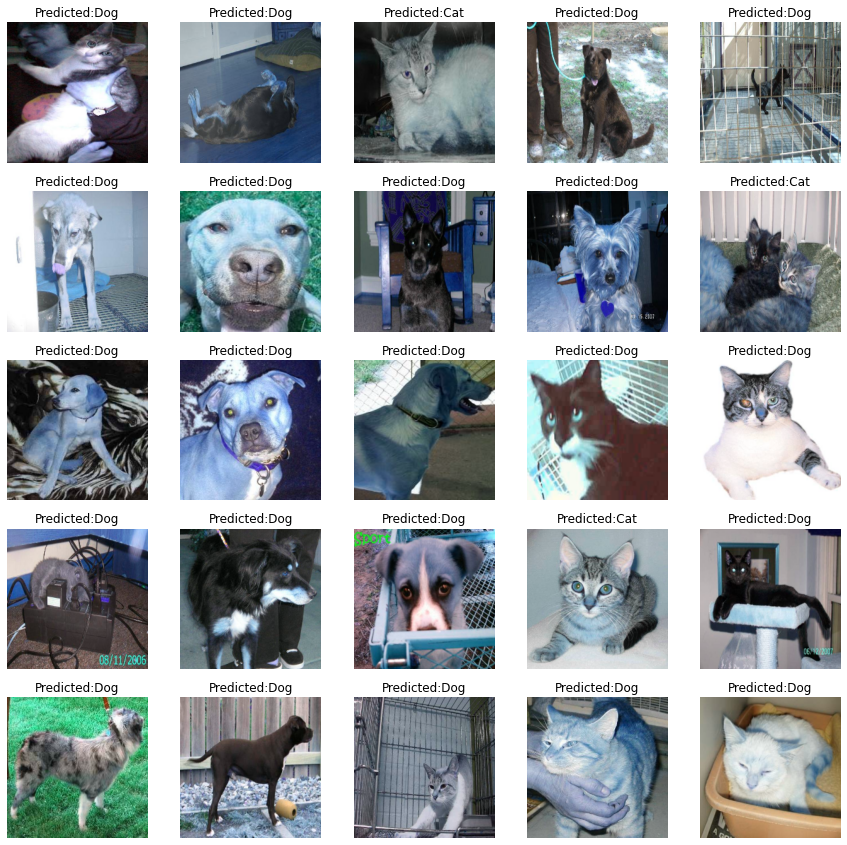

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = ResNet32.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test_data):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = (ResNet32.predict([data])[0])
    img_list.append(img_idx)
    pred_list.append(round(predicted[1]))

100%|██████████| 12500/12500 [11:55<00:00, 17.48it/s]


In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission_Resnet32.csv", index=False)